In [1]:
import os
os.chdir('../')

In [2]:
device='cpu'

In [3]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR

## Set the datasets you want to test the model on

In [21]:
num_steps = 4000
num_states = 25
dsets = []
dset_labels = []

In [22]:
# Unbiased 1D Walk
dsets.append(
    inputs.Sim1DWalk(
        num_steps=num_steps,left_right_stay_prob=[1, 1, 1],
        num_states=num_states
        )
)
dset_labels.append('1D Walk (no bias)')

In [23]:
# Stay-biased 1D Walk
dsets.append(
    inputs.Sim1DWalk(
        num_steps=num_steps,left_right_stay_prob=[1, 7, 1],
        num_states=num_states
        )
)
dset_labels.append('1D Walk (stay-bias)')

In [24]:
# Right-biased 1D Walk
dsets.append(
    inputs.Sim1DWalk(
        num_steps=num_steps,left_right_stay_prob=[1, 1, 7],
        num_states=num_states
        )
)
dset_labels.append('1D Walk (right-bias)')

In [25]:
# 2D Levy Flight
dsets.append(
    inputs.Sim2DLevyFlight(
        num_steps=num_steps,
        walls=int(np.sqrt(num_states)-1)
        )
)
dset_labels.append('Levy Flight')

In [26]:
# 2D Random Walk
dsets.append(
    inputs.Sim2DWalk(
        num_steps=num_steps,
        num_states=num_states
        )
)
dset_labels.append('2D Walk')

## Specify model you want to test

In [12]:
model_file = './trained_models/quals_fig5_models/model_1.pt'
net = STDP_SR(num_states=num_states, gamma=0.4)
net.load_state_dict(torch.load(model_file))
net.ca3.set_differentiability(False) 

## Run model on various datasets

In [13]:
with torch.no_grad():
    acc_curves = []
    for dset in dsets:
        dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
        dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
        net.ca3.set_num_states(dset.num_states)
        acc_curve = []
        for step in range(dset.num_steps):
            curr_dg_input = dg_inputs[step].unsqueeze(0)
            curr_dg_mode = dg_modes[step].unsqueeze(0)
            _, outputs = net(curr_dg_input, curr_dg_mode, reset=False)
            real_T = net.ca3.get_real_T()
            est_T = net.ca3.get_T()
            error = real_T - est_T.detach().numpy()
            mae = np.mean(np.abs(error))
            acc_curve.append(mae)
        acc_curves.append(acc_curve)

## Generate plots

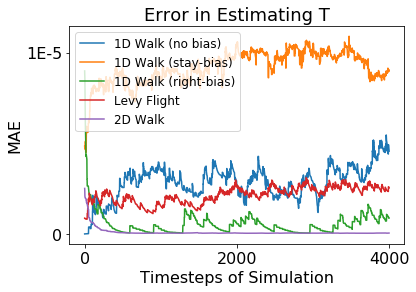

In [30]:
plt.figure()
for idx, label in enumerate(dset_labels):
    plt.plot(acc_curves[idx], label=label)
plt.title("Error in Estimating T", fontsize=18)
plt.ylabel("MAE", fontsize=16)
plt.yticks([0, 1E-5], ['0', '1E-5'], fontsize=16)
plt.xlabel("Timesteps of Simulation", fontsize=16)
plt.xticks([0, 2000, 4000], fontsize=16)
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.savefig('acc_through_time.png', dpi=500)
plt.savefig('acc_through_time.pdf', dpi=500)
plt.show()

In [ ]:
d